<center>
<h1> Clustering </h1>
<center>


In [ ]:
# Data handling
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Clustering
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score,  silhouette_samples

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


## Funciones

In [ ]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(8, 5))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
def prepare_pca(n_components, data):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
        
    return df_matrix

## Análisis preliminar

In [ ]:
dataset_clean = pd.read_csv('dataset_clean.csv')
dataset = dataset_clean.drop(['Unnamed: 0'], axis=1)
dataset.head(5)

sender_state  sender_zipcode receiver_state  receiver_zipcode shipment_type  \
0           SP            1039             SP             14500      standard   
1           SP            3004             PB             58670      standard   
2           SP            3262             RJ             22723      standard   
3           SP           12237             SP             18682      standard   
4           SP            9350             AP             68908      standard   

   quantity  service status         date_created            date_sent  \
0         1        1   done  2019-03-10 00:00:00  2019-03-11 14:34:00   
1         1        1   done  2019-03-08 00:00:00  2019-03-09 10:48:00   
2         1        2   done  2019-02-21 00:00:00  2019-02-23 02:02:16   
3         1        2   done  2019-02-25 00:00:00  2019-02-28 03:05:36   
4         1        1   done  2019-02-15 00:00:00  2019-02-15 11:28:00   

            date_visit  shipment_days  
0  2019-03-18 09:52:00            5.0  
1  2019-03-18 15:16:00            5.0  
2  2019-03-01 21:27:00            4.0  
3  2019-03-07 15:01:00            2.0  
4  2019-03-11 13:18:00           13.0

In [ ]:
dataset = dataset.drop(['sender_state'], axis=1) #Todos los envíos salen de San Pablo

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496954 entries, 0 to 496953
Data columns (total 11 columns):
sender_zipcode      496954 non-null int64
receiver_state      496954 non-null object
receiver_zipcode    496954 non-null int64
shipment_type       496954 non-null object
quantity            496954 non-null int64
service             496954 non-null int64
status              496954 non-null object
date_created        496954 non-null object
date_sent           496954 non-null object
date_visit          496954 non-null object
shipment_days       496954 non-null float64
dtypes: float64(1), int64(4), object(6)
memory usage: 41.7+ MB


Antes de determinar los features importantes para aplicar el método de clustering procederemos a aplicar label enconder de las variables receiver_state, shipment_type y status los cuales nos servirán para visualizar si existe alguna posible correlación entre las variables no determinada hasta el momento.

### Enconding de variables categóricas

#### Label encoder receiver_state

In [ ]:
receiver_state_le = 'receiver_state'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset[receiver_state_le])

LabelEncoder()

In [ ]:
dataset['receiver_state_le'] = le.transform(dataset[receiver_state_le]) 
dataset.sample()

sender_zipcode receiver_state  receiver_zipcode shipment_type  \
283075            3262             PE             50610      standard   

        quantity  service status         date_created            date_sent  \
283075         1        1   done  2019-02-21 00:00:00  2019-02-22 19:53:00   

                 date_visit  shipment_days  receiver_state_le  
283075  2019-03-13 08:31:00           10.0                 15

#### Label encoder shipment_type

In [ ]:
shipment_type_le = 'shipment_type'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset[shipment_type_le])

LabelEncoder()

In [ ]:
dataset['shipment_type_le'] = le.transform(dataset[shipment_type_le]) 
dataset.sample()

sender_zipcode receiver_state  receiver_zipcode shipment_type  \
116483            8060             MG             36328      standard   

        quantity  service status         date_created            date_sent  \
116483         2        1   done  2019-03-15 00:00:00  2019-03-18 08:55:00   

                 date_visit  shipment_days  receiver_state_le  \
116483  2019-03-27 09:11:00            7.0                 10   

        shipment_type_le  
116483                 1

#### Label encoder status

In [ ]:
status_le = 'status'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset[status_le])

LabelEncoder()

In [ ]:
dataset['status_le'] = le.transform(dataset[status_le]) 
dataset.sample()

sender_zipcode receiver_state  receiver_zipcode shipment_type  \
492041            8210             MG             37704      standard   

        quantity  service status         date_created            date_sent  \
492041         1        1   done  2019-02-24 00:00:00  2019-02-25 14:40:00   

                 date_visit  shipment_days  receiver_state_le  \
492041  2019-03-01 17:16:00            4.0                 10   

        shipment_type_le  status_le  
492041                 1          0

Ahora construimos un nuevo dataset con los features sender_zipcode, receiver_state_le, receiver_zipcode, shipmente_type_le, quantity, service y status_le (es decir, omitiremos los features relacionados con fechas) y ploteamos un gráfico de correlación.

In [ ]:
new_dataset = dataset[['sender_zipcode','receiver_state_le','receiver_zipcode',
                          'shipment_type_le', 'quantity','service',
                          'status_le','shipment_days']]
new_dataset.head()

sender_zipcode  receiver_state_le  receiver_zipcode  shipment_type_le  \
0            1039                 25             14500                 1   
1            3004                 14             58670                 1   
2            3262                 18             22723                 1   
3           12237                 25             18682                 1   
4            9350                  3             68908                 1   

   quantity  service  status_le  shipment_days  
0         1        1          0            5.0  
1         1        1          0            5.0  
2         1        2          0            4.0  
3         1        2          0            2.0  
4         1        1          0           13.0

### Gráfico de correlación

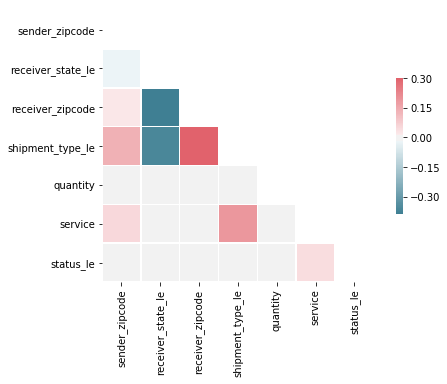

In [ ]:
plot_corr(new_dataset.drop(['shipment_days'], axis=1))

In [ ]:
new_dataset.describe()

sender_zipcode  receiver_state_le  receiver_zipcode  shipment_type_le  \
count   496954.000000      496954.000000     496954.000000     496954.000000   
mean      8311.780350          18.086175      40109.953885          0.569085   
std       5088.770378           7.317123      30969.152069          0.534334   
min       1001.000000           0.000000       1001.000000          0.000000   
25%       3680.000000          10.000000      13172.000000          0.000000   
50%       7400.000000          22.000000      31340.000000          1.000000   
75%      13281.750000          25.000000      70720.000000          1.000000   
max      19970.000000          26.000000      99990.000000          2.000000   

            quantity        service      status_le  shipment_days  
count  496954.000000  496954.000000  496954.000000  496954.000000  
mean        1.278197       1.510401       0.008804       5.399830  
std         0.661643       1.818551       0.093414       4.974941  
min         1.000000       0.000000       0.000000       0.000000  
25%         1.000000       0.000000       0.000000       2.000000  
50%         1.000000       1.000000       0.000000       4.000000  
75%         1.000000       2.000000       0.000000       8.000000  
max         5.000000      12.000000       1.000000      90.000000

En el gráfico de correlación anterior observamos distintos grados de correlación entre las variables, donde el color rojo es un indicador de una correlación positiva entre las variables y el color azul de una negativa. Particularmente nos interesan aquellos pares de features que muestran una correlación positiva (color rojo):

- receiver_zipcode y sender_zipcode
- shipment_type y sender_zipcode
- service y sender_zipcode
- shipment_type y receiver_zipcode
- service y shipment_type
- status y service

Dado que los features shipment_type, service y status poseen muy pocas categorías o una distribución en la cual predomina uno de los valores, consideramos que eligiendo estos features nos obtendremos información relevante que nos ayuden a encontrar clusters. La intuición nos lleva a pensar que receiver_zipcode y sender_zipcode serían dos features adecuados para desarrollar un modelo de clustering inicial.

De todas maneras, mostramos los gráficos de aquellos pares de variables que dieron correlaciones positivas.

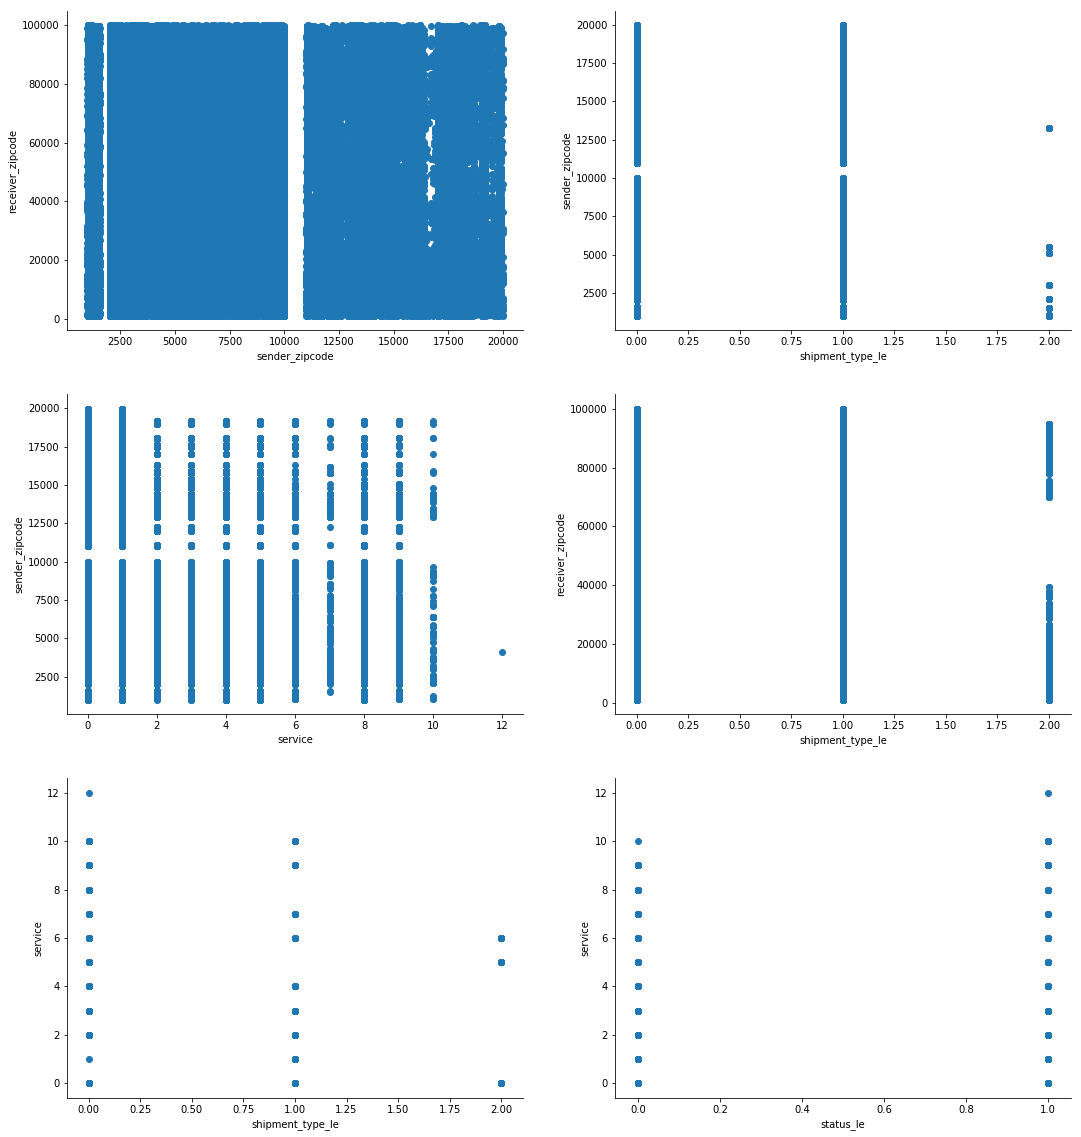

In [ ]:
# Visualización de los datos
plt.figure(figsize=(18,20))

plt.subplot2grid((3,2),(0,0))
plt.scatter(new_dataset['sender_zipcode'], 
            new_dataset['receiver_zipcode'])
plt.xlabel('sender_zipcode')
plt.ylabel('receiver_zipcode')
sns.despine()

plt.subplot2grid((3,2),(0,1))
plt.scatter(new_dataset['shipment_type_le'], 
            new_dataset['sender_zipcode'])
plt.xlabel('shipment_type_le')
plt.ylabel('sender_zipcode')
sns.despine()

plt.subplot2grid((3,2),(1,0))
plt.scatter(new_dataset['service'], 
            new_dataset['sender_zipcode'])
plt.xlabel('service')
plt.ylabel('sender_zipcode')
sns.despine()

plt.subplot2grid((3,2),(1,1))
plt.scatter(new_dataset['shipment_type_le'], 
            new_dataset['receiver_zipcode'])
plt.xlabel('shipment_type_le')
plt.ylabel('receiver_zipcode')
sns.despine()


plt.subplot2grid((3,2),(2,0))
plt.scatter(new_dataset['shipment_type_le'], 
            new_dataset['service'])
plt.xlabel('shipment_type_le')
plt.ylabel('service')
sns.despine()


plt.subplot2grid((3,2),(2,1))
plt.scatter(new_dataset['status_le'], 
            new_dataset['service'])
plt.xlabel('status_le')
plt.ylabel('service')
sns.despine()

Dado que los gráficos anteriores confirman en cierto sentido nuestra intuición, elegimos entonces los features sender_zipcode y receiver_zipcode para aplicar un método de clusterings. En su gráfico correspondiente se observa la presencia de dos (o tres) posibles clusters separados por dos (o tres) líneas blancas.

In [ ]:
features_for_clustering = new_dataset[['sender_zipcode','receiver_zipcode']]
features_for_clustering.sample(5)

sender_zipcode  receiver_zipcode
336909            4413             34012
494052           11380             22450
65546             2710             15600
20523            14010             78593
175363            8471              5302

## Clustering con dos features

### kmeans con k=2

#### Distancia euclidea

Teniendo en cuenta las observaciones anteriores, aplicaremos en primera instancia el método de clustering Kmeans utilizando 2 clusters  con el objetivo de verificar si efectivamente se corresponden a dos grupos distintos. Asimismo calcuremos la inercia que es una medida de cuan coherentes son los clusters internamente. La misma se define como la suma de los cuadrados de las distancias dentro de cada cluster y por lo tanto mientras más cercana a cero mejor (en primer lugar utilizaremos la distancia euclídea). 

In [ ]:
kmeans2=KMeans(n_clusters=2).fit(features_for_clustering)
print(kmeans2)
print('Suma de los cuadrados de las distancias al clusters / Inercia: ', kmeans2.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Suma de los cuadrados de las distancias al clusters / Inercia:  98851842158470.11


In [ ]:
df_clusters=features_for_clustering.copy()
df_clusters['kmeans_2']=kmeans2.labels_
df_clusters.head()

sender_zipcode  receiver_zipcode  kmeans_2
0            1039             14500         1
1            3004             58670         0
2            3262             22723         1
3           12237             18682         1
4            9350             68908         0

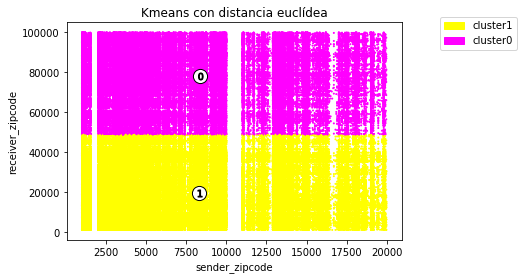

In [ ]:
colores=['yellow','magenta']
variable1='sender_zipcode'
variable2='receiver_zipcode'
f1 = df_clusters['sender_zipcode'].values
f2 = df_clusters['receiver_zipcode'].values
f3 = df_clusters['kmeans_2']

asignar=[]
l=len(f3)

for k in range(l): #asigna a cada cluster un respectivo color
    asignar.append(colores[f3[k]-1])

plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='cluster1')
patch2 = mpatches.Patch(color=colores[1], label='cluster0')

# Labeling the clusters 
centers = kmeans2.cluster_centers_

# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

plt.legend(handles=[patch1,patch2], bbox_to_anchor=(1.1, 1.05))

plt.title('Kmeans con distancia euclídea')
plt.show()

#### Distancia coseno

In [ ]:
normalized_vectors = preprocessing.normalize(features_for_clustering)
normalized_kmeans2 = KMeans(n_clusters=2)
normalized_kmeans2.fit(normalized_vectors)
df_clusters['kmeans_cos_2']=normalized_kmeans2.labels_
df_clusters.head()

sender_zipcode  receiver_zipcode  kmeans_2  kmeans_cos_2
0            1039             14500         1             0
1            3004             58670         0             0
2            3262             22723         1             0
3           12237             18682         1             1
4            9350             68908         0             0

In [ ]:
print('Suma de los cuadrados de las distancias al clusters / Inercia: ', 
      normalized_kmeans2.inertia_)

Suma de los cuadrados de las distancias al clusters / Inercia:  14538.564929494973


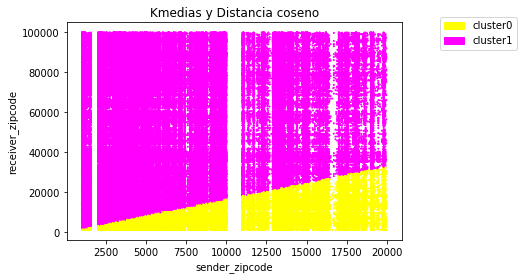

In [ ]:
f3 = df_clusters['kmeans_cos_2']

asignar=[]
l=len(f3)

for k in range(l): #asigna a cada cluster un respectivo color
    asignar.append(colores[f3[k]-1])

plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='cluster0')
patch2 = mpatches.Patch(color=colores[1], label='cluster1')

plt.legend(handles=[patch1,patch2], bbox_to_anchor=(1.1, 1.05))

plt.title('Kmedias y Distancia coseno')
plt.show()

Los resultados anteriores muestran que kmeans no clusterizó como habiamos supuesto. Sin embargo observamos que utilizando la distancia euclídea, kmeans podría estar agrupando los envíos, y especialmente los códigos postales de llegada, con algún criterio de cercanía. No olvidemos que todos los envíos salen de San Pablo, con lo cual podriamos estar hablando de cercanía desde la ciudad San Pablo. A simple vista los resultados con la distancia coseno no tienen ninguna explicación intuitiva.

Aplicaremos el método de Elbow para obtener el valor de k que minimiza la inercia. 

### Método de Elbow : distancia euclídea y distancia coseno

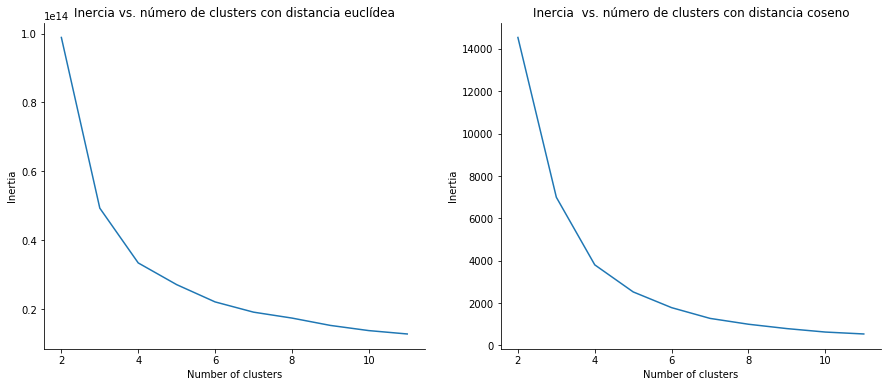

In [ ]:
# n_clusters de 2 a 9
plt.figure(figsize=(15,6))

plt.subplot2grid((1,2),(0,0))
scores = [KMeans(n_clusters=i+2).fit(features_for_clustering).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inercia vs. número de clusters con distancia euclídea")
sns.despine()

plt.subplot2grid((1,2),(0,1))
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inercia  vs. número de clusters con distancia coseno")
sns.despine()

En ambos casos observamos que la inercia comienza a estabilizarse en k=6.
A continuación tomaremos este valor para visualizar cómo quedan los clusters usando sólo la distancia euclídea.

### kmeans con k= 6

In [ ]:
kmeans6=KMeans(n_clusters=6).fit(features_for_clustering)
print(kmeans6)
print('Suma de los cuadrados de las distancias al clusters / Inercia: ', kmeans6.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Suma de los cuadrados de las distancias al clusters / Inercia:  22129556934352.945


In [ ]:
df_clusters['kmeans_6']=kmeans6.labels_
df_clusters.head()

sender_zipcode  receiver_zipcode  kmeans_2  kmeans_cos_2  kmeans_6
0            1039             14500         1             0         2
1            3004             58670         0             0         5
2            3262             22723         1             0         2
3           12237             18682         1             1         2
4            9350             68908         0             0         3

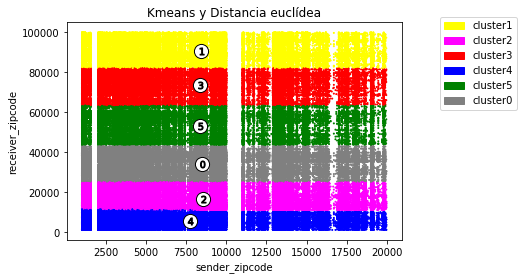

In [ ]:
colores=['yellow','magenta','red','blue','green','grey']
variable1='sender_zipcode'
variable2='receiver_zipcode'
f1 = df_clusters['sender_zipcode'].values
f2 = df_clusters['receiver_zipcode'].values
f3 = df_clusters['kmeans_6']

asignar=[]
l=len(f3)

for k in range(l): #asigna a cada cluster un respectivo color
    asignar.append(colores[f3[k]-1])

plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='cluster1')
patch2 = mpatches.Patch(color=colores[1], label='cluster2')
patch3 = mpatches.Patch(color=colores[2], label='cluster3')
patch4 = mpatches.Patch(color=colores[3], label='cluster4')
patch5 = mpatches.Patch(color=colores[4], label='cluster5')
patch6 = mpatches.Patch(color=colores[5], label='cluster0')


# Labeling the clusters 
centers = kmeans6.cluster_centers_

# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
            marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6], bbox_to_anchor=(1.1, 1.05))

plt.title('Kmeans y Distancia euclídea')
plt.show()

Del gráfico anterior observamos que kmeans continua particionando los códigos postales de llegada en grupos bastante definidos. Con el fin de verificar las agrupaciones obtenidas hasta el momento realizaremos gráficos de siluetas  y calcularemos el promedio del coeficiente de silueta dentro de cada cluster tomando una muestra del dataset. Valores del coeficiente de silueta cercanos a 1 indican que la muestra está lejos de los clusters vecinos, valores negativos del mismo nos indican que algunos elementos tendrían que haber sido asignados a otro cluster y el valor 0 nos muestra puntos muy cerca de la frontera de deciisión.

### Gráficos de silueta

In [ ]:
sampling = features_for_clustering.sample(40000)

Para n_clusters = 2 El silhouette_score promedio es : 0.6816390259336466
Para n_clusters = 3 El silhouette_score promedio es : 0.5852309545922273
Para n_clusters = 4 El silhouette_score promedio es : 0.5286038176180436
Para n_clusters = 5 El silhouette_score promedio es : 0.44292742715986294
Para n_clusters = 6 El silhouette_score promedio es : 0.4096122670311317
Para n_clusters = 7 El silhouette_score promedio es : 0.4008434711426225
Para n_clusters = 8 El silhouette_score promedio es : 0.39078216491122847


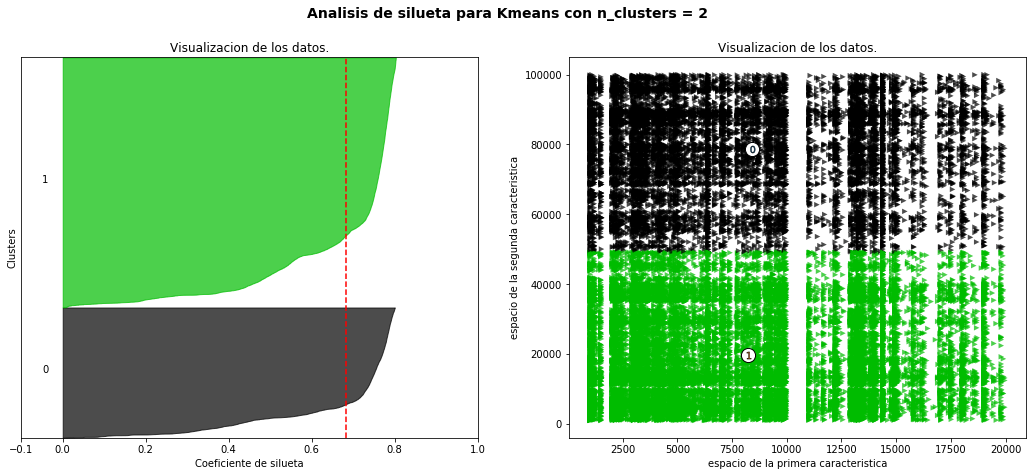

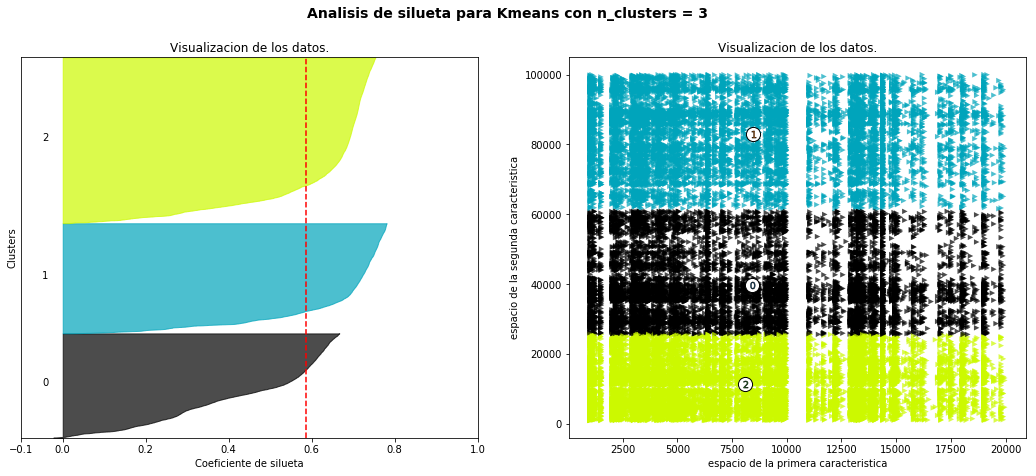

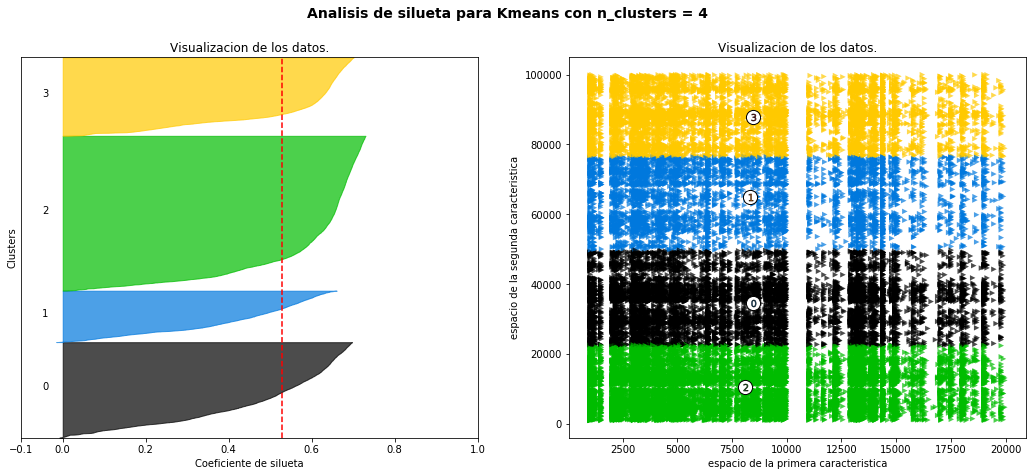

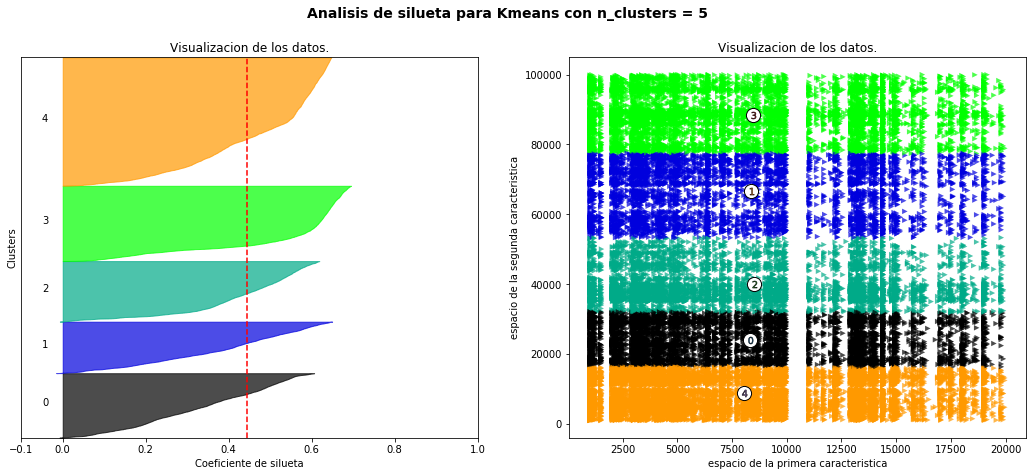

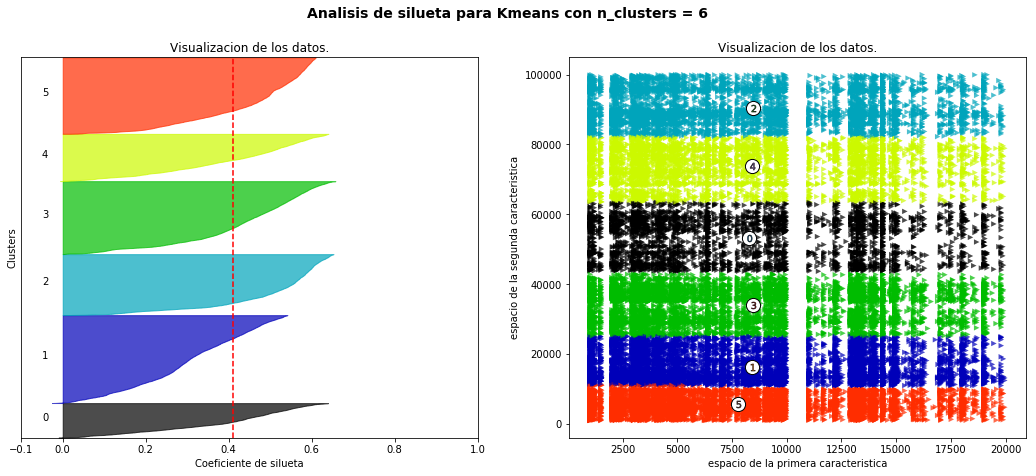

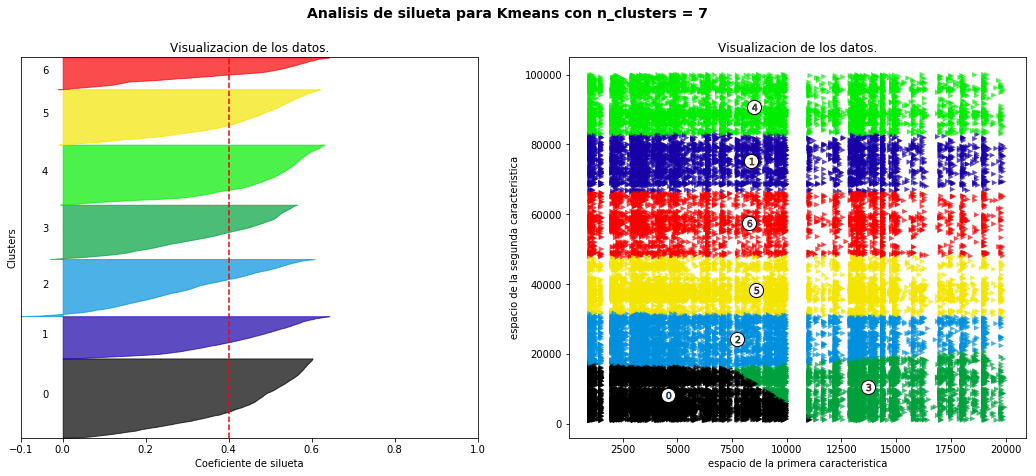

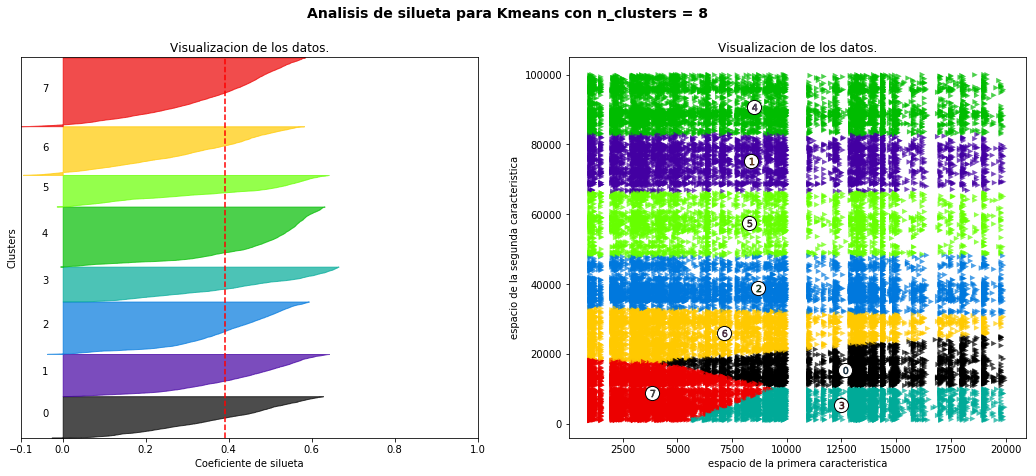

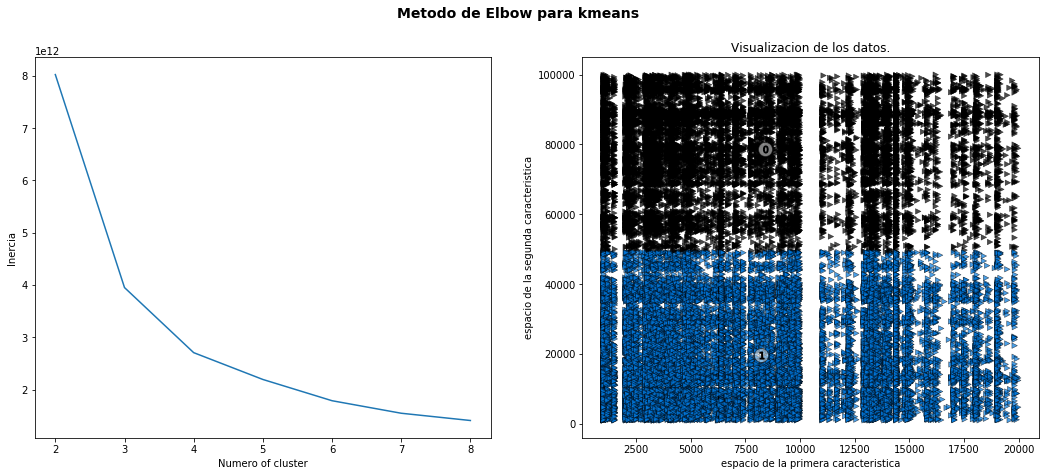

In [ ]:
range_n_clusters = [2,3, 4, 5, 6,7,8]
sse ={}

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sampling) + (n_clusters + 1) * 10])
    
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(sampling)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sampling, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sampling, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("Coeficiente de silueta")
    ax1.set_ylabel("Clusters")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sampling.iloc[:, 0], sampling.iloc[:, 1], 
                marker='>', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k',lw=0.5)

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmeans "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo de Elbow para kmeans "),
                 fontsize=14, fontweight='bold')

ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(sampling)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(sampling.iloc[:, 0], sampling.iloc[:, 1], marker='>', 
            s=30, lw=0.5, alpha=0.7,c=colors, edgecolor='k')

#**Labeling the clusters**
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", 
            alpha=0.5, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

plt.show()

En las visualizaciones anteriores observamos que si bien k=2 tiene un valor de inercia bastante alto no se observan valores negativos en los coeficientes de silueta y ninguno de los clusters está por debajo del valor de silueta promedio el cual, comparado con los demás valores calculados, es el que se acerca más a 1. 

Para las demás elecciones k tenemos valores del coeficiente de silueta negativos y un promedio más bajo en el coeficiente de silueta, además del hecho de que las agrupaciones comienzan a ser más desequilibradas unas con otras. Vemos también que a medida que aumenta el número de clusters se observan valores más negativos en el coeficiente de silueta.

Con la elección de sólo dos features creemos que k=2 y k=4 dieron los resultados más óptimos, el primero por lo que se mencionó anteriormente y el segundo porque brinda un buen balance entre el valor de la inercia y el coeficiente de silueta.

A continuación ampliaremos la elección de features con la idea de observar si estos resultados se mantienen.

## Clustering con más de dos features

En este caso elegimos los features:

- sender_zipcode
- receiver_zipcode
- receiver_state_le
- service

In [ ]:
clustering_ds = new_dataset[['sender_zipcode','receiver_zipcode', 
              'receiver_state_le','service']]

clustering_ds.head()

sender_zipcode  receiver_zipcode  receiver_state_le  service
0            1039             14500                 25        1
1            3004             58670                 14        1
2            3262             22723                 18        2
3           12237             18682                 25        2
4            9350             68908                  3        1

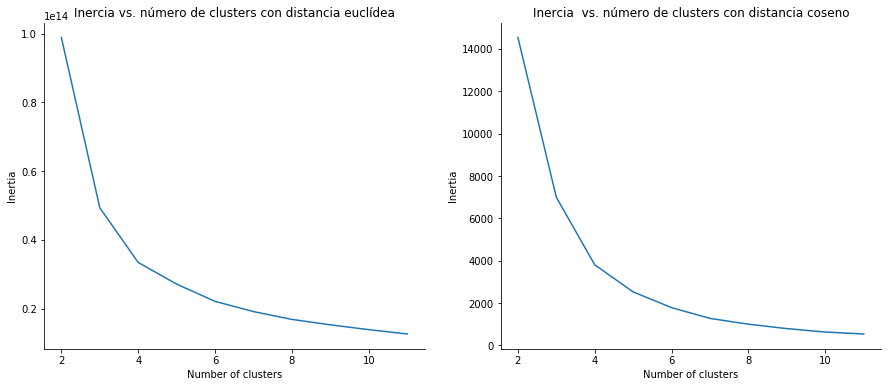

In [ ]:
# n_clusters de 2 a 9
plt.figure(figsize=(15,6))

plt.subplot2grid((1,2),(0,0))
scores = [KMeans(n_clusters=i+2).fit(clustering_ds).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inercia vs. número de clusters con distancia euclídea")
sns.despine()

plt.subplot2grid((1,2),(0,1))
normalized_vectores = preprocessing.normalize(clustering_ds)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inercia  vs. número de clusters con distancia coseno")
sns.despine()

Nuevamente el valor de la inercia comienza a estabilizarse a partir de k=6 tanto utilizando la distancia euclídea como la distancia coseno. A continuación observemos como resultan los gráficos de siluetas en una muestra del dataset.

#### Gráficos de silueta

In [ ]:
sampling_version2 = clustering_ds.sample(40000)

Para n_clusters = 2 El silhouette_score promedio es : 0.6790915654510307
Para n_clusters = 3 El silhouette_score promedio es : 0.584485675146067
Para n_clusters = 4 El silhouette_score promedio es : 0.5307749246705193
Para n_clusters = 5 El silhouette_score promedio es : 0.4910385575491576
Para n_clusters = 6 El silhouette_score promedio es : 0.4124236559740532
Para n_clusters = 7 El silhouette_score promedio es : 0.3992652659266273
Para n_clusters = 8 El silhouette_score promedio es : 0.40532458997357573


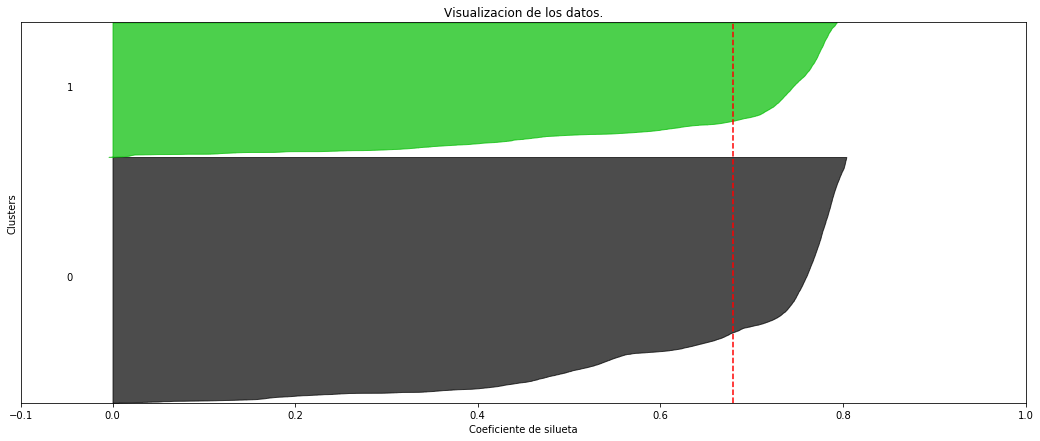

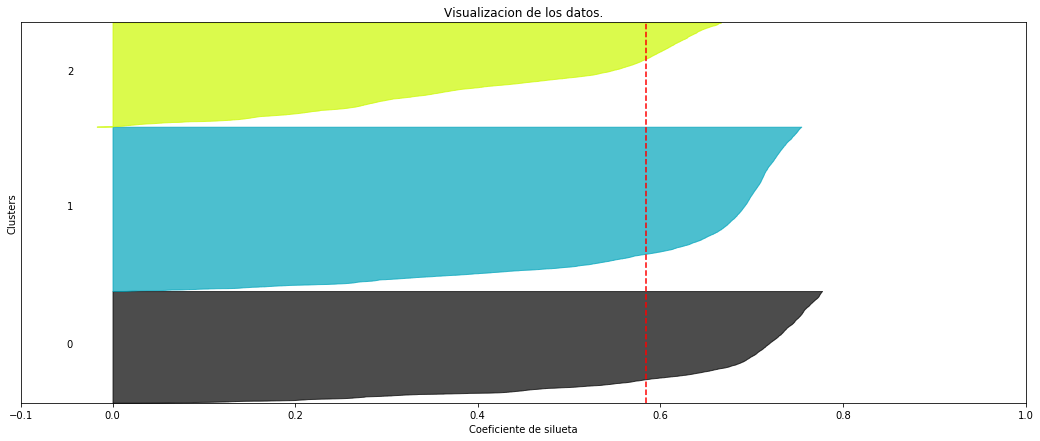

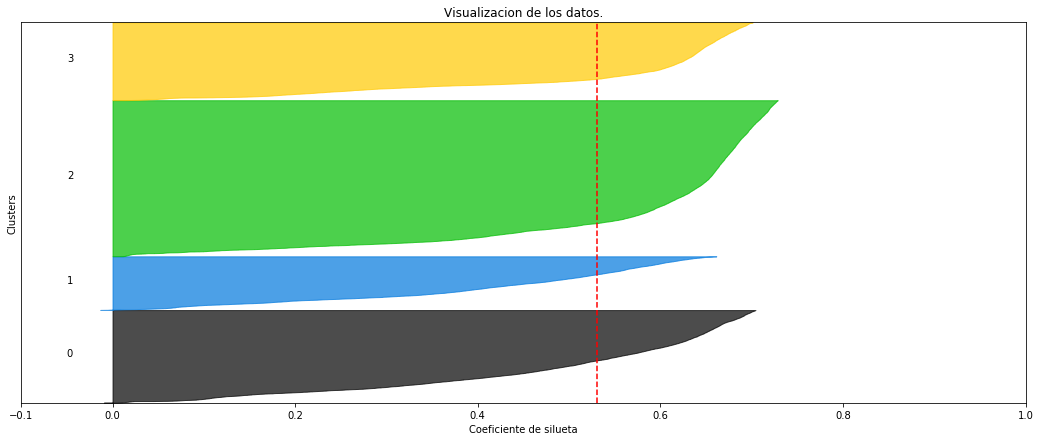

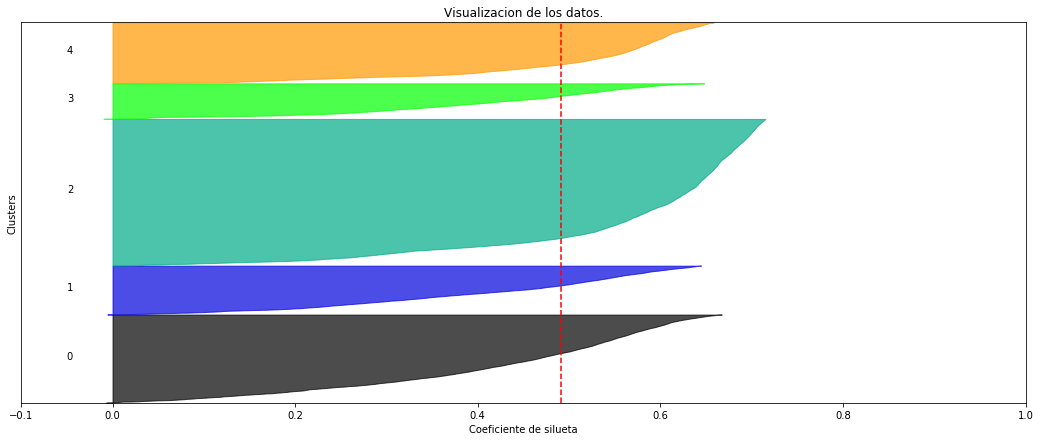

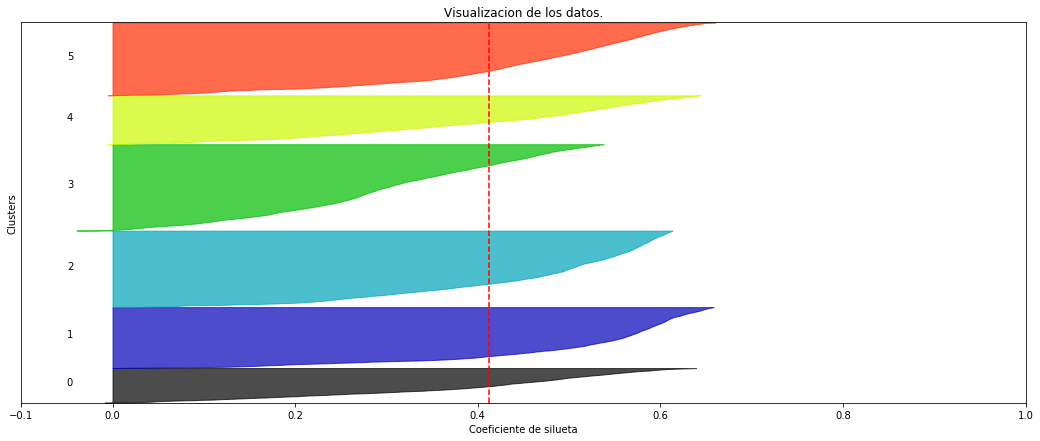

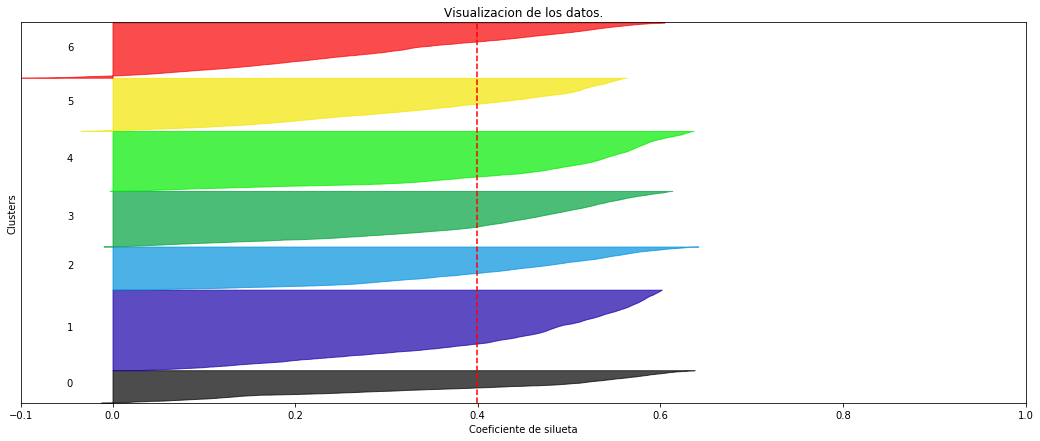

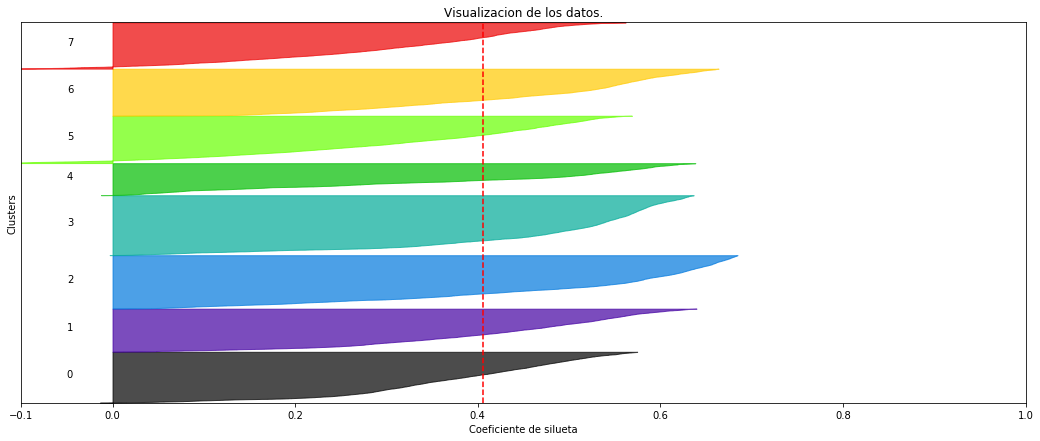

In [ ]:
range_n_clusters = [2,3, 4, 5, 6,7,8]
sse ={}

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig  = plt.figure(figsize=(6,25))
    fig.set_size_inches(18, 7)
    plt.xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(sampling_version2) + (n_clusters + 1) * 10])
    
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(sampling_version2)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sampling_version2, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sampling_version2, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.title("Visualizacion de los datos.")
    plt.xlabel("Coeficiente de silueta")
    plt.ylabel("Clusters")
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.show()

Las visualizaciones anteriores son bastante similares al análisis previo, obteniendo con k=2 un promedio del coeficiente de silueta más cercano a 1 y clusters levemente más equilibrados. A partir de k=3 se observa que comienzan a aparecer valores del coeficiente de silueta negativos, haciendose más evidentes desde k=6.

## Reducción de dimensionalidad con PCA

A continuación aplicaremos embeddings sobre los features seleccionados utilizando PCA con el fin de ver si encontramos alguna información nueva. Haremos pruebas utilizando kmeans con k=2, 3 y 4.

In [ ]:
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(clustering_ds)

kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(clustering_ds)

kmeans4 = KMeans(n_clusters=4)
kmeans4.fit(clustering_ds)

pca_df = prepare_pca(3, clustering_ds)

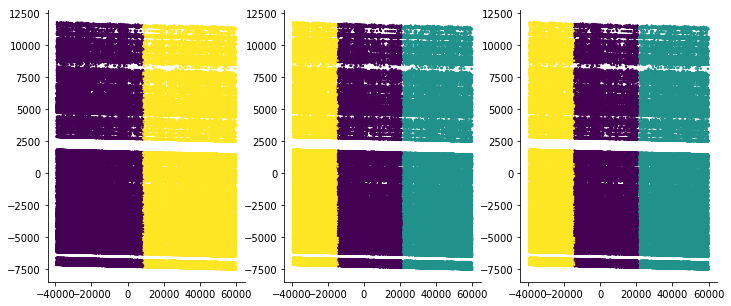

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot2grid((1,3),(0,0))
plt.scatter(x=pca_df.x, y=pca_df.y,c=kmeans2.labels_, label=kmeans2.labels_, s=2)
sns.despine()

plt.subplot2grid((1,3),(0,1))
plt.scatter(x=pca_df.x, y=pca_df.y,c=kmeans3.labels_, label=kmeans3.labels_, s=2)
sns.despine()

plt.subplot2grid((1,3),(0,2))
plt.scatter(x=pca_df.x, y=pca_df.y,c=kmeans3.labels_, label=kmeans3.labels_, s=2)
sns.despine()

In [ ]:
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans2.labels_))
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans3.labels_))
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans4.labels_))

cantidad de datos por cluster con kmedias:  Counter({0: 322171, 1: 174783})
cantidad de datos por cluster con kmedias:  Counter({2: 215454, 1: 145944, 0: 135556})
cantidad de datos por cluster con kmedias:  Counter({0: 200577, 2: 124867, 3: 101984, 1: 69526})


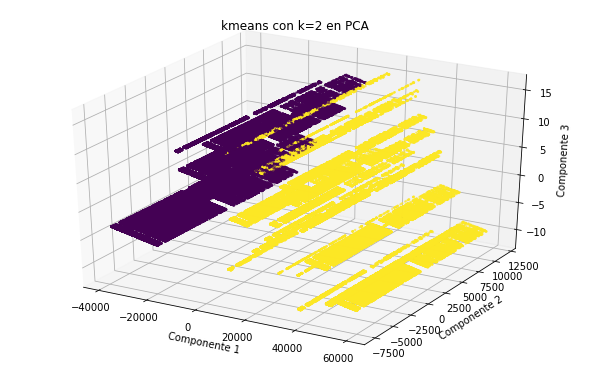

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(pca_df.x, pca_df.y, pca_df.z,c=kmeans2.labels_,label=kmeans2.labels_, s=2)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.title('kmeans con k=2 en PCA')
plt.show()


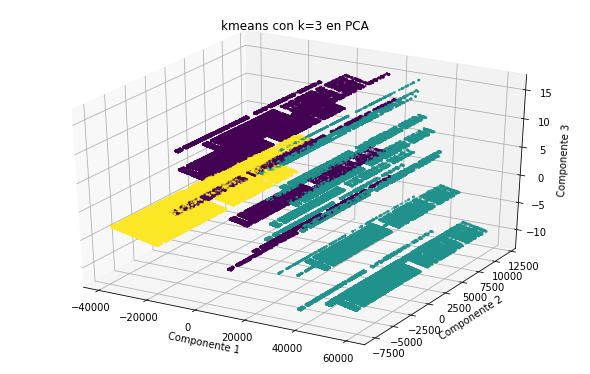

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(pca_df.x, pca_df.y, pca_df.z,c=kmeans3.labels_,label=kmeans3.labels_, s=2)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.title('kmeans con k=3 en PCA')
plt.show()

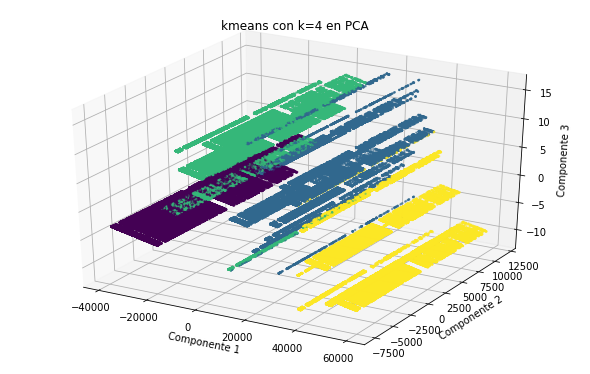

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(pca_df.x, pca_df.y, pca_df.z,c=kmeans4.labels_,label=kmeans4.labels_, s=2)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.title('kmeans con k=4 en PCA')
plt.show()

In [ ]:
clustering_ds_ship = new_dataset[['sender_zipcode','receiver_zipcode', 
              'receiver_state_le','service', 'shipment_days']]

clustering_ds_ship.head()

sender_zipcode  receiver_zipcode  receiver_state_le  service  shipment_days
0            1039             14500                 25        1            5.0
1            3004             58670                 14        1            5.0
2            3262             22723                 18        2            4.0
3           12237             18682                 25        2            2.0
4            9350             68908                  3        1           13.0

In [ ]:
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(clustering_ds_ship.drop(['shipment_days'], axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
df_clusters=clustering_ds_ship.copy()
df_clusters['kmeans2']=kmeans2.labels_
df_clusters.head()

sender_zipcode  receiver_zipcode  receiver_state_le  service  \
0            1039             14500                 25        1   
1            3004             58670                 14        1   
2            3262             22723                 18        2   
3           12237             18682                 25        2   
4            9350             68908                  3        1   

   shipment_days  kmeans2  
0            5.0        1  
1            5.0        0  
2            4.0        1  
3            2.0        1  
4           13.0        0

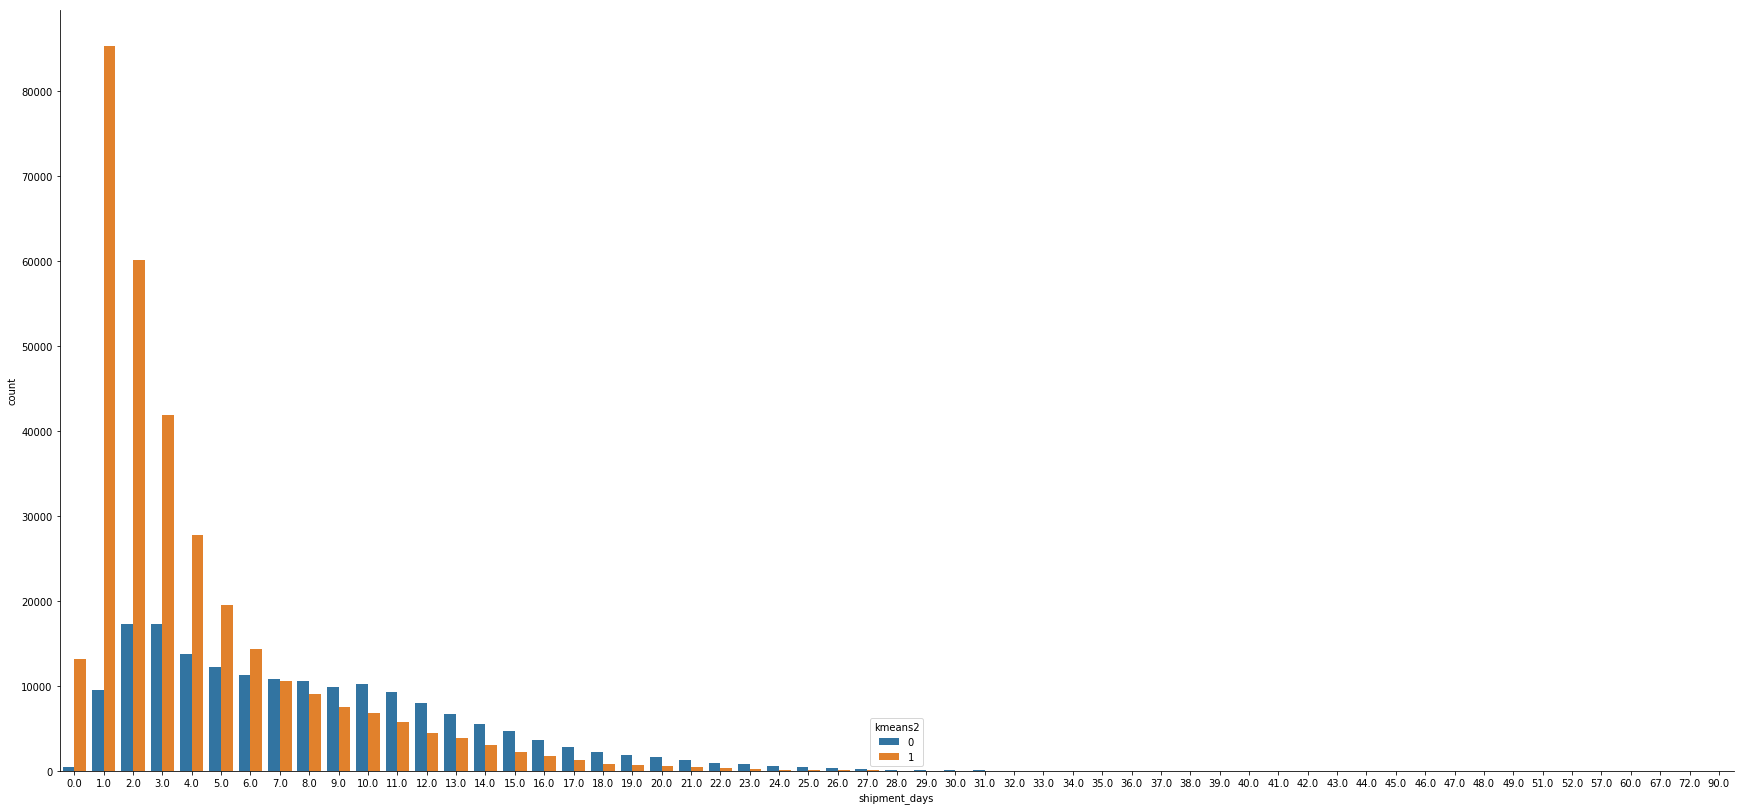

In [ ]:
plt.figure(figsize=(30,14))
sns.countplot(x="shipment_days", hue="kmeans2", data=df_clusters)
sns.despine()